In [1]:
import gstools as gs
from gstools import CovModel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
from tqdm import tqdm
import xarray as xr
import matplotlib.ticker as mticker
import warnings

In [2]:
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from multiprocess import Pool
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import cmcrameri.cm as cmc
from cartopy import geodesic as cgeod
import os

In [3]:
params={     
    'axes.labelsize'  : '16',   
    'axes.titlesize'  : '16',  
    'xtick.labelsize' :'16',
    'ytick.labelsize' :'16',    
    'lines.linewidth' : '2' ,   
    'legend.fontsize' : '12', 
    'figure.figsize'   : '12, 7'    
}
plt.rcParams.update(params)

In [4]:
os.chdir("/g/data/k10/dl6968/Semi-variogram_AU/")

In [5]:
spec_id = 51026

In [6]:
df_scale = pd.read_csv(f"./data/all_AU_p90_500km/{spec_id}_pair_scale_spherical_moving_list_all_events.csv")


In [7]:
df_bins = pd.read_csv(f"./data/all_AU_p90_500km/{spec_id}_pair_bins_moving_list_all_events.csv")

In [8]:
df_stations_p90 = pd.read_csv(f"./data/demo_csv/{spec_id}_station_moving_list_all_events.csv")

In [31]:
df_scale[(df_scale["scale"]>0) & (df_scale["scale"]<200)]

,Unnamed: 0,extreme_dates,scale
41,41,1950-06-24,146.559866
63,63,1956-03-01,193.220985
72,72,1958-03-09,129.479394
98,98,1963-08-24,160.641325
131,131,1970-10-19,182.288610
164,164,1978-01-04,196.550301
198,198,1985-12-07,158.393458
211,211,1989-10-26,155.782509
278,278,2004-12-07,93.127077
279,279,2004-12-08,116.476931


In [9]:
len(df_scale)

364

In [10]:
for days in np.concatenate(np.argwhere(df_scale["scale"].values>1000)):
    n10_df = df_stations_p90[(df_stations_p90["Day"]==days) & (df_stations_p90["flag"]==0) & (df_stations_p90["distance"]<=500)]

    n11_df = df_stations_p90[(df_stations_p90["Day"]==days) & (df_stations_p90["flag"]>0)& (df_stations_p90["distance"]<=500)]
    print(f"Day: {days}")
    print(f"N11/N10:{len(n11_df)/len(n10_df)}")
    print(f"len_scale:"+ str(df_scale["scale"].iloc[days])+" km")

Day: 1
N11/N10:0.28337874659400547
len_scale:1205.3868555416568 km
Day: 18
N11/N10:0.17076023391812867
len_scale:1186.137210332272 km
Day: 19
N11/N10:0.182883939038687
len_scale:1276.5263481659388 km
Day: 32
N11/N10:1.0518962075848304
len_scale:1532.0162759342013 km
Day: 59
N11/N10:0.5426470588235294
len_scale:1859.739266811796 km
Day: 66
N11/N10:0.34887218045112783
len_scale:174395.47390032894 km
Day: 81
N11/N10:0.40154867256637167
len_scale:1418.7592878980745 km
Day: 82
N11/N10:0.41482444733420026
len_scale:2274.7876950978257 km
Day: 84
N11/N10:0.17037037037037037
len_scale:128636.98250835716 km
Day: 87
N11/N10:0.42777155655095184
len_scale:1406.712713972366 km
Day: 99
N11/N10:0.3149847094801223
len_scale:1396.1150017483874 km
Day: 103
N11/N10:0.34285714285714286
len_scale:2243.694480476452 km
Day: 134
N11/N10:0.36888454011741684
len_scale:1056.9734329240523 km
Day: 139
N11/N10:0.5665914221218962
len_scale:1548.1868487603665 km
Day: 142
N11/N10:0.1609674728940784
len_scale:1019.01980

In [10]:
# df_bins_1980 = pd.read_csv(f"./data/all_AU_p90_1980/{spec_id}_pair_bins_moving_list_all_events.csv")
# df_stations_p90_1980 = pd.read_csv(f"./data/all_AU_p90_1980/{spec_id}_station_moving_list_all_events.csv")

In [11]:
class Stab(CovModel):
    def variogram(self, r):
        return self.nugget + self.sill * (1 - np.exp(-(3 * r) / self.len_scale))


In [13]:
# df_bins["Day"][df_bins["Date"]=='1988-08-22'].iloc[0]

## check fitting model

In [341]:
df_scale[(100<df_scale["scale"])&(df_scale["scale"]<350)]

,Unnamed: 0,extreme_dates,scale
2,2,1941-01-23,124.637019
7,7,1942-10-10,347.629292
9,9,1942-12-29,317.962251
17,17,1944-08-09,308.829403
19,19,1944-09-16,268.022697
...,...,...,...
367,367,2022-09-08,103.432192
369,369,2022-10-08,126.140395
370,370,2022-10-21,102.575258
374,374,2023-11-20,158.665436


In [194]:
days = 97
bins = df_bins["Bins"][df_bins["Day"]==days]
gamma = df_bins["gamma"][df_bins["Day"]==days]
bins_fit =  bins#np.append(0,bins)
gamma_fit = gamma#np.append(0,gamma)

In [195]:
df_bins["gamma"].min()/2

0.0125780389276533

In [200]:
fit_model = Stab(dim=2)  # Choose model type (Exponential, Spherical, Gaussian, etc.)
_ = fit_model.fit_variogram(bins_fit, gamma_fit, sill = 0.5, nugget=0.025)#,sill=gamma.max(),nugget=0.5-gamma.max())
y_fit = fit_model.variogram(bins)
fit_model

Stab(dim=2, var=0.475, len_scale=1.23e+02, nugget=0.025)

In [201]:
fit_model.sill

0.5

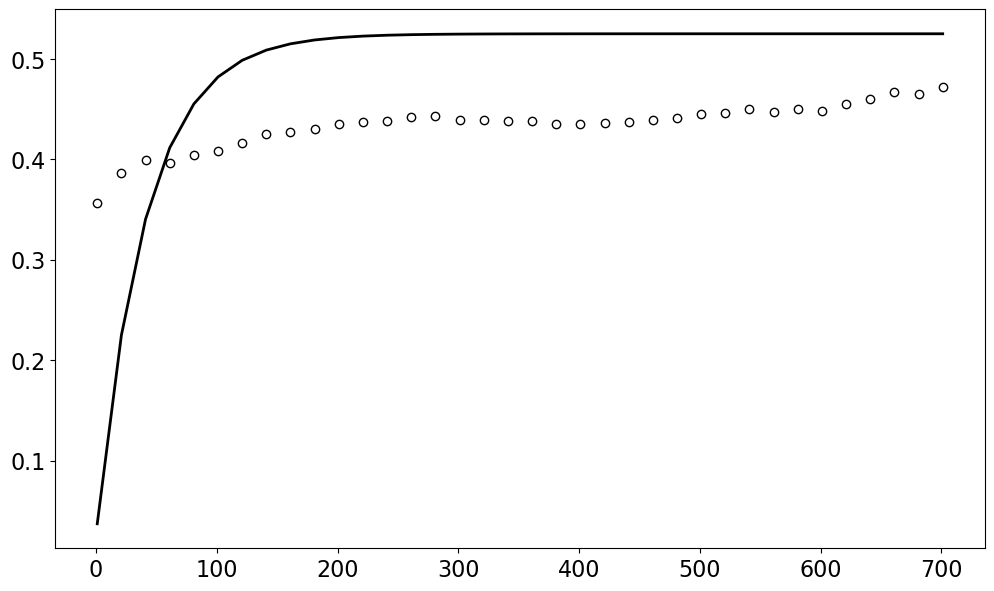

In [202]:
plt.plot(bins, y_fit, color="k", linewidth=2, label = "Exponential fitted")
plt.scatter(bins, gamma,facecolor="w", edgecolor="k", label="Similarity at each bin")

In [298]:
df_scale[df_scale["scale"]>500]

,Unnamed: 0,extreme_dates,scale
3,3,1997-01-02,620.581394
12,12,1998-01-26,624.020969
28,28,2001-02-11,517.855653
40,40,2003-12-21,561.484856
54,54,2006-04-04,757.168829
74,74,2012-03-14,771.851223


# map plotting


In [11]:
center_lat, center_lon =-31.5627, 146.7179# -27.3410 , 150.0621#-12.3722,  130.8653# -27.5436, 152.3375#-27.3410 , 150.0621#  -24.1967, 150.3714 #

N11/N10:0.1686541737649063
len_scale:151.687734526661 km


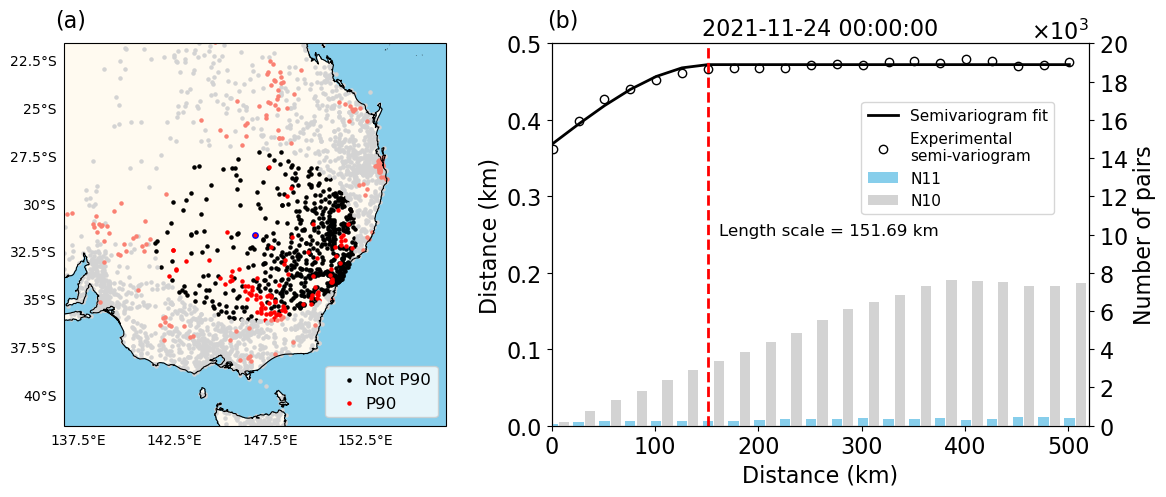

In [81]:
days = 349#361
#361 - why nugget and sill are important for 40082
 #242

#374
#318
#330
date = df_stations_p90["Date"][df_stations_p90["Day"]==days].iloc[0]

radius_km = 500
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121, projection=ccrs.PlateCarree())

n10_df = df_stations_p90[(df_stations_p90["Day"]==days) & (df_stations_p90["flag"]==0) & (df_stations_p90["distance"]<=500)]

n11_df = df_stations_p90[(df_stations_p90["Day"]==days) & (df_stations_p90["flag"]>0)& (df_stations_p90["distance"]<=500)]
# plt.scatter(df.loc[df["Longitude"]<147, "Longitude"], 
#             df.loc[df["Longitude"]<147, "Latitude"], color="lightgray",s=5, transform=ccrs.PlateCarree(), zorder=0)

ax.scatter(n10_df["lon"], n10_df["lat"], color="k", s=5, transform=ccrs.PlateCarree(), label="Not P90")

ax.scatter(n11_df["lon"], n11_df["lat"], color="r",s=5, transform=ccrs.PlateCarree(), label="P90")



n10_out = df_stations_p90[(df_stations_p90["Day"]==days) & (df_stations_p90["flag"]==0) & (df_stations_p90["distance"]>500)]

n11_out = df_stations_p90[(df_stations_p90["Day"]==days) & (df_stations_p90["flag"]>0)& (df_stations_p90["distance"]>500)]

ax.scatter(n10_out["lon"], n10_out["lat"], color="lightgray", s=5, transform=ccrs.PlateCarree())#, label="Not P90")

ax.scatter(n11_out["lon"], n11_out["lat"], color="salmon",s=5, transform=ccrs.PlateCarree())#, label="P90")

# center_lat, center_lon = df_stations_p90[(df_stations_p90["Day"]==days)]["cent_lat"].iloc[0], df_stations_p90[(df_stations_p90["Day"]==days)]["cent_lon"].iloc[0]
ax.scatter(center_lon, center_lat, s=15, edgecolor="blue", facecolor="red", transform=ccrs.PlateCarree() )

# plt.plot(nearby_bom_lon_1min, nearby_bom_lat_1min, "rx", label = "BoM", transform=ccrs.PlateCarree())
g = cgeod.Geodesic()
circle = g.circle(lon=center_lon, lat=center_lat, radius=radius_km * 1000.0)
## do this to remove the gap of the circle
circ_lon = np.append(circle[:,0], circle[0,0])
circ_lat = np.append(circle[:,1], circle[0,1])
# Plot the circle
# ax.plot(circ_lon, circ_lat, color='blue', transform=ccrs.PlateCarree())#, label="r = 350 km")

ax.legend(ncol=1,loc="best", handletextpad=-0.01)#, bbox_to_anchor=((1.01,1.01)))

ax.coastlines('10m', color="black",linewidth=0.8)
ax.add_feature(cfeature.LAND, color='floralwhite')  
ax.add_feature(cfeature.OCEAN, color='skyblue')  
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.0, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.set_xlim([center_lon-10, center_lon+10])
ax.set_ylim([center_lat-10, center_lat+10])
plt.tight_layout()
#############################################
ax2 = fig.add_subplot(122)
bins = df_bins["Bins"][(df_bins["Day"]==days) & (df_bins["Bins"]<=501)].values
gamma = df_bins["gamma"][(df_bins["Day"]==days) & (df_bins["Bins"]<=501)].values

cov_model = gs.Spherical(dim=2)
_ = cov_model.fit_variogram(bins[gamma>0], gamma[gamma>0])
y_fit = cov_model.variogram(bins)
cov_scale = cov_model.len_scale
ax2.plot(bins, y_fit, color="k",label = "Semivariogram fit")



ax2.scatter(bins, gamma,facecolor="w", edgecolor="k", label="Experimental \nsemi-variogram")
# ax2.legend(loc="center right")
ax2.set_xlim([0,520])
ax2.set_ylim([0,0.5])
ax2.set_xlabel("Distance (km)")
ax2.set_ylabel("Distance (km)")

ax2t = ax2.twinx() 
ax2t.bar(bins, df_bins["N11"][(df_bins["Day"]==days) & (df_bins["Bins"]<=501)],width=10,facecolor="skyblue",label="N11")
ax2t.bar(bins+11, df_bins["N10"][(df_bins["Day"]==days) & (df_bins["Bins"]<=501)],width=10,facecolor="lightgray",zorder=1,label="N10")
# ax2t.plot( [df_scale["scale"].iloc[days] for i in np.arange(0,46000,1000)], np.arange(0,46000,1000), "r--")
lines, labels = ax2.get_legend_handles_labels()
lines2, labels2 = ax2t.get_legend_handles_labels()
ax2t.legend(lines + lines2, labels + labels2, loc="center right",ncol=1,fontsize=11, bbox_to_anchor=((0.95,0.7)))
ax2t.axvline(x=cov_scale, color="r", linestyle="--") 
ax2t.text( cov_scale+10, 10000, r"Length scale = " + f"{cov_scale:.02f} km", fontsize = 12)
ax2t.set_xlim([0,520])
ax2t.set_ylim([0,20000])


ax2t.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
ax2t.ticklabel_format(style="sci", axis="y", scilimits=(3,3))  # Force 10³ notation

ax2t.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))


ax2t.set_ylabel("Number of pairs")
plt.title(df_bins["Date"][df_bins["Day"]==days].iloc[0])
plt.tight_layout()
plt.gcf().text(0.07, 0.95,"(a)", fontsize=16)
plt.gcf().text(0.48, 0.95,"(b)", fontsize=16)
print(f"N11/N10:{len(n11_df)/len(n10_df)}")
print(f"len_scale:{cov_scale} km")
plt.savefig("/g/data/k10/dl6968/Semi-variogram_AU/figures/Figure_demo_small_51026.png", dpi=200, bbox_inches="tight")

N11/N10:0.5105042016806722
len_scale:427.4604711017105 km


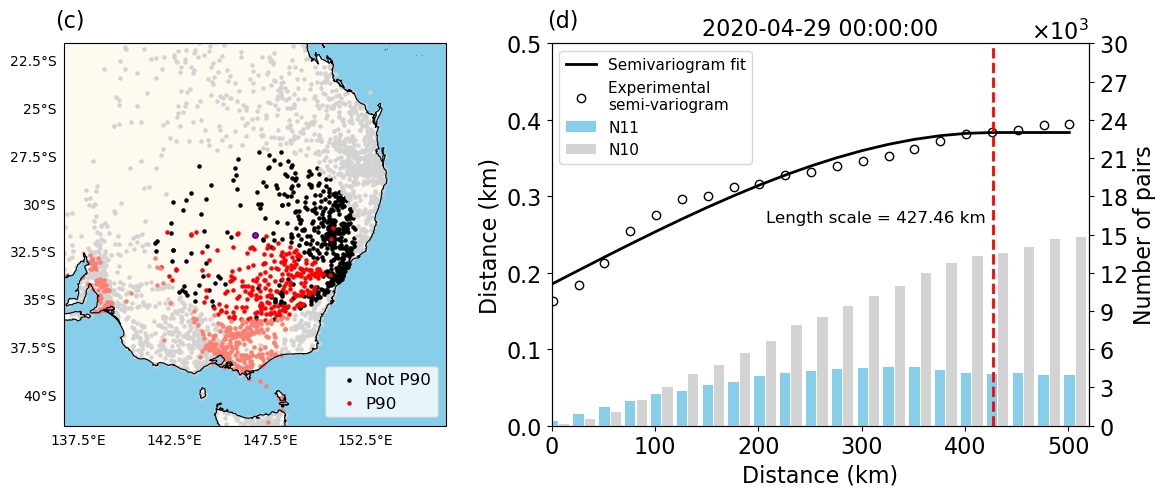

In [80]:
days = 341#361
#361 - why nugget and sill are important for 40082
 #242

#374
#318
#330
date = df_stations_p90["Date"][df_stations_p90["Day"]==days].iloc[0]

radius_km = 500
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121, projection=ccrs.PlateCarree())

n10_df = df_stations_p90[(df_stations_p90["Day"]==days) & (df_stations_p90["flag"]==0) & (df_stations_p90["distance"]<=500)]

n11_df = df_stations_p90[(df_stations_p90["Day"]==days) & (df_stations_p90["flag"]>0)& (df_stations_p90["distance"]<=500)]
# plt.scatter(df.loc[df["Longitude"]<147, "Longitude"], 
#             df.loc[df["Longitude"]<147, "Latitude"], color="lightgray",s=5, transform=ccrs.PlateCarree(), zorder=0)

ax.scatter(n10_df["lon"], n10_df["lat"], color="k", s=5, transform=ccrs.PlateCarree(), label="Not P90")

ax.scatter(n11_df["lon"], n11_df["lat"], color="r",s=5, transform=ccrs.PlateCarree(), label="P90")



n10_out = df_stations_p90[(df_stations_p90["Day"]==days) & (df_stations_p90["flag"]==0) & (df_stations_p90["distance"]>500)]

n11_out = df_stations_p90[(df_stations_p90["Day"]==days) & (df_stations_p90["flag"]>0)& (df_stations_p90["distance"]>500)]

ax.scatter(n10_out["lon"], n10_out["lat"], color="lightgray", s=5, transform=ccrs.PlateCarree())#, label="Not P90")

ax.scatter(n11_out["lon"], n11_out["lat"], color="salmon",s=5, transform=ccrs.PlateCarree())#, label="P90")

# center_lat, center_lon = df_stations_p90[(df_stations_p90["Day"]==days)]["cent_lat"].iloc[0], df_stations_p90[(df_stations_p90["Day"]==days)]["cent_lon"].iloc[0]
ax.scatter(center_lon, center_lat, s=15, edgecolor="blue", facecolor="red", transform=ccrs.PlateCarree() )

# plt.plot(nearby_bom_lon_1min, nearby_bom_lat_1min, "rx", label = "BoM", transform=ccrs.PlateCarree())
g = cgeod.Geodesic()
circle = g.circle(lon=center_lon, lat=center_lat, radius=radius_km * 1000.0)
## do this to remove the gap of the circle
circ_lon = np.append(circle[:,0], circle[0,0])
circ_lat = np.append(circle[:,1], circle[0,1])
# Plot the circle
# ax.plot(circ_lon, circ_lat, color='blue', transform=ccrs.PlateCarree())#, label="r = 350 km")

ax.legend(ncol=1,loc="best", handletextpad=-0.01)#, bbox_to_anchor=((1.01,1.01)))

ax.coastlines('10m', color="black",linewidth=0.8)
ax.add_feature(cfeature.LAND, color='floralwhite')  
ax.add_feature(cfeature.OCEAN, color='skyblue')  
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.0, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.set_xlim([center_lon-10, center_lon+10])
ax.set_ylim([center_lat-10, center_lat+10])
plt.tight_layout()
#############################################################

ax2 = fig.add_subplot(122)
bins = df_bins["Bins"][(df_bins["Day"]==days) & (df_bins["Bins"]<=501)].values
gamma = df_bins["gamma"][(df_bins["Day"]==days) & (df_bins["Bins"]<=501)].values

cov_model = gs.Spherical(dim=2)
_ = cov_model.fit_variogram(bins[gamma>0], gamma[gamma>0])
y_fit = cov_model.variogram(bins)
cov_scale = cov_model.len_scale
ax2.plot(bins, y_fit, color="k",label = "Semivariogram fit")

# ax2.plot(bins[1:], df_bins["y_fit"][df_bins["Day"]==days].iloc[1:], color="k", linewidth=2, label = "Exponential fit")
# ax2.text( cov_scale-300, 0.3, r"Length scale = " + f"{cov_scale:.02f} km", fontsize = 12)

ax2.scatter(bins, gamma,facecolor="w", edgecolor="k", label="Experimental \nsemi-variogram")
# ax2.legend(loc="center right")
ax2.set_xlim([0,520])
ax2.set_ylim([0,0.5])
ax2.set_xlabel("Distance (km)")
ax2.set_ylabel("Distance (km)")

ax2t = ax2.twinx() 
ax2t.bar(bins, df_bins["N11"][(df_bins["Day"]==days) & (df_bins["Bins"]<=501)],width=10,facecolor="skyblue",label="N11")
ax2t.bar(bins+11, df_bins["N10"][(df_bins["Day"]==days) & (df_bins["Bins"]<=501)],width=10,facecolor="lightgray",zorder=1,label="N10")
# ax2t.plot( [df_scale["scale"].iloc[days] for i in np.arange(0,46000,1000)], np.arange(0,46000,1000), "r--")
lines, labels = ax2.get_legend_handles_labels()
lines2, labels2 = ax2t.get_legend_handles_labels()
leg = ax2t.legend(lines + lines2, labels + labels2, loc="upper left",ncol=1,fontsize=11)#, bbox_to_anchor=((0.97,0.7)))
leg.set_zorder(-1)
ax2t.axvline(x=cov_scale, color="r", linestyle="--") 
ax2t.text( cov_scale-220, 16000, r"Length scale = " + f"{cov_scale:.02f} km", fontsize = 12)
ax2t.set_xlim([0,520])
ax2t.set_ylim([0,30000])


ax2t.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
ax2t.ticklabel_format(style="sci", axis="y", scilimits=(3,3))  # Force 10³ notation

ax2t.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))


ax2t.set_ylabel("Number of pairs")
plt.title(df_bins["Date"][df_bins["Day"]==days].iloc[0])
plt.tight_layout()
plt.gcf().text(0.07, 0.95,"(c)", fontsize=16)
plt.gcf().text(0.48, 0.95,"(d)", fontsize=16)
print(f"N11/N10:{len(n11_df)/len(n10_df)}")
print(f"len_scale:{cov_scale} km")
plt.savefig("/g/data/k10/dl6968/Semi-variogram_AU/figures/Figure_demo_large_51026.png", dpi=200, bbox_inches="tight")

In [56]:
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return "DJF"
    elif month in [3, 4, 5]:
        return "MAM"
    elif month in [6, 7, 8]:
        return "JJA"
    elif month in [9, 10, 11]:
        return "SON"

def weighted_mean(x,field="gamma"):
    if np.sum(x["Norm_Weight"]) > 0:
        return np.sum(x[field] * x["Norm_Weight"]) / np.sum(x["Norm_Weight"])
    else: 
        return 0

df_bins = df_bins[(df_bins["y_fit"]>0) & (df_bins["Bins"]<=501)]
df_bins["Date"] = pd.to_datetime(df_bins["Date"])
df_bins["Season"] = df_bins["Date"].apply(get_season)
df_bins["Tot"] = df_bins["N11"] + df_bins["N10"]
N11_arr = np.zeros((np.unique(df_bins[df_bins["Season"]=="SON"]["Day"]).shape[0], len(df_bins[df_bins["Day"]==1]["Bins"])))
N10_arr = np.zeros((np.unique(df_bins[df_bins["Season"]=="SON"]["Day"]).shape[0], len(df_bins[df_bins["Day"]==1]["Bins"])))

for i, days in enumerate(np.unique(df_bins[df_bins["Season"]=="SON"]["Day"])):
    N11_arr[i,:] = df_bins[df_bins["Day"]==days]["N11"].values
    N10_arr[i,:] = df_bins[df_bins["Day"]==days]["N10"].values
N11_sum = np.nansum(N11_arr, axis=0)
N10_sum = np.nansum(N10_arr, axis=0)

In [57]:
df_season = pd.read_csv(f"./data/all_AU_p90_500km/{spec_id}_season_bins_moving_list_all_events.csv")

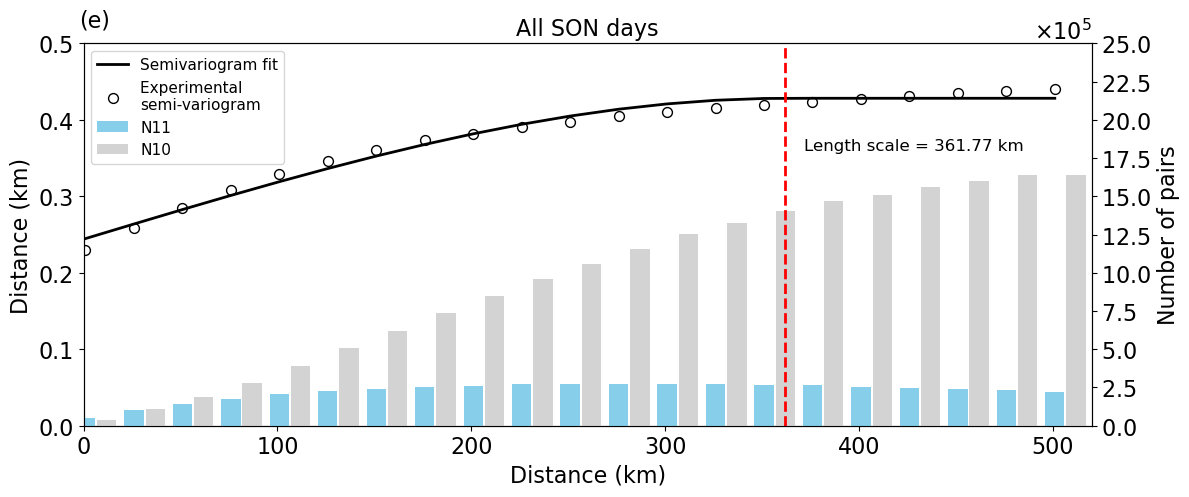

In [79]:
fig = plt.figure(figsize=(12,5))
ax2 = fig.add_subplot(111)
bins = df_season["Bins"][df_season["Bins"]<=501]
gamma = df_season["SON_gamma"][df_season["Bins"]<=501]

cov_model = gs.Spherical(dim=2)
_ = cov_model.fit_variogram(bins[gamma>0], gamma[gamma>0])
y_fit = cov_model.variogram(bins)
cov_scale = cov_model.len_scale
ax2.plot(bins, y_fit, color="k",label = "Semivariogram fit")

# ax2.plot(bins[1:], df_bins["y_fit"][df_bins["Day"]==days].iloc[1:], color="k", linewidth=2, label = "Exponential fit")
# ax2.text( cov_scale-300, 0.3, r"Length scale = " + f"{cov_scale:.02f} km", fontsize = 12)

ax2.scatter(bins, gamma,s = 50,facecolor="w", edgecolor="k", label="Experimental \nsemi-variogram")
# ax2.legend(loc="center right")
ax2.set_xlim([0,520])
ax2.set_ylim([0,0.5])
ax2.set_xlabel("Distance (km)")
ax2.set_ylabel("Distance (km)")

ax2t = ax2.twinx() 
ax2t.bar(bins, N11_sum,width=10,facecolor="skyblue",label="N11")
ax2t.bar(bins+11, N10_sum,width=10,facecolor="lightgray",zorder=1,label="N10")
# ax2t.plot( [df_scale["scale"].iloc[days] for i in np.arange(0,46000,1000)], np.arange(0,46000,1000), "r--")
lines, labels = ax2.get_legend_handles_labels()
lines2, labels2 = ax2t.get_legend_handles_labels()
leg = ax2t.legend(lines + lines2, labels + labels2, loc="upper left",ncol=1,fontsize=11)
leg.set_zorder(-1)
ax2t.axvline(x=cov_scale, color="r", linestyle="--") 
ax2t.text( cov_scale+10, 1800000, r"Length scale = " + f"{cov_scale:.02f} km", fontsize = 12)
ax2t.set_xlim([0,520])
ax2t.set_ylim([0,2500000])


ax2t.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
ax2t.ticklabel_format(style="sci", axis="y", scilimits=(5,5))  # Force 10³ notation

ax2t.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))


ax2t.set_ylabel("Number of pairs")
plt.title("All SON days")
plt.tight_layout()
plt.gcf().text(0.07, 0.95,"(e)", fontsize=16)
# plt.gcf().text(0.48, 0.95,"(d)", fontsize=16)
plt.savefig("/g/data/k10/dl6968/Semi-variogram_AU/figures/Figure_demo_season.png", dpi=200, bbox_inches="tight")

Text(0.48, 0.95, '(d)')

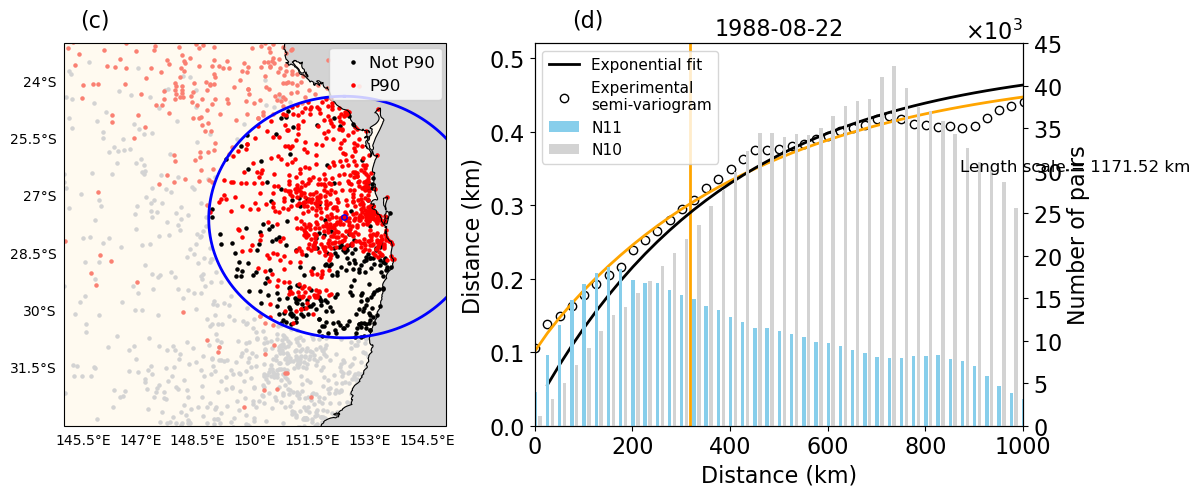

In [27]:
days = 363#361
#361 - why nugget and sill are important for 40082
 #242
#374
#318
#330
date = df_stations_p90["Date"][df_stations_p90["Day"]==days].iloc[0]

radius_km = 350
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121, projection=ccrs.PlateCarree())

n10_df = df_stations_p90[(df_stations_p90["Day"]==days) & (df_stations_p90["flag"]==0) & (df_stations_p90["distance"]<=350)]

n11_df = df_stations_p90[(df_stations_p90["Day"]==days) & (df_stations_p90["flag"]>0)& (df_stations_p90["distance"]<=350)]
# plt.scatter(df.loc[df["Longitude"]<147, "Longitude"], 
#             df.loc[df["Longitude"]<147, "Latitude"], color="lightgray",s=5, transform=ccrs.PlateCarree(), zorder=0)

ax.scatter(n10_df["lon"], n10_df["lat"], color="k", s=5, transform=ccrs.PlateCarree(), label="Not P90")

ax.scatter(n11_df["lon"], n11_df["lat"], color="r",s=5, transform=ccrs.PlateCarree(), label="P90")



n10_out = df_stations_p90[(df_stations_p90["Day"]==days) & (df_stations_p90["flag"]==0) & (df_stations_p90["distance"]>350)]

n11_out = df_stations_p90[(df_stations_p90["Day"]==days) & (df_stations_p90["flag"]>0)& (df_stations_p90["distance"]>350)]

ax.scatter(n10_out["lon"], n10_out["lat"], color="lightgray", s=5, transform=ccrs.PlateCarree())#, label="Not P90")

ax.scatter(n11_out["lon"], n11_out["lat"], color="salmon",s=5, transform=ccrs.PlateCarree())#, label="P90")

# center_lat, center_lon = df_stations_p90[(df_stations_p90["Day"]==days)]["cent_lat"].iloc[0], df_stations_p90[(df_stations_p90["Day"]==days)]["cent_lon"].iloc[0]
ax.scatter(center_lon, center_lat, s=15, edgecolor="blue", facecolor="red", transform=ccrs.PlateCarree() )

# plt.plot(nearby_bom_lon_1min, nearby_bom_lat_1min, "rx", label = "BoM", transform=ccrs.PlateCarree())
g = cgeod.Geodesic()
circle = g.circle(lon=center_lon, lat=center_lat, radius=radius_km * 1000.0)
## do this to remove the gap of the circle
circ_lon = np.append(circle[:,0], circle[0,0])
circ_lat = np.append(circle[:,1], circle[0,1])
# Plot the circle
ax.plot(circ_lon, circ_lat, color='blue', transform=ccrs.PlateCarree())#, label="r = 350 km")

ax.legend(ncol=1,loc="upper right", handletextpad=-0.01, bbox_to_anchor=((1.01,1.01)))

ax.coastlines('10m', color="black",linewidth=0.8)
ax.add_feature(cfeature.LAND, color='floralwhite')  
ax.add_feature(cfeature.OCEAN, color='lightgrey')  
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.0, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.set_xlim([145,155])
ax.set_ylim([-33,-23])
plt.tight_layout()

ax2 = fig.add_subplot(122)
bins = df_bins["Bins"][df_bins["Day"]==days].values
gamma = df_bins["gamma"][df_bins["Day"]==days].values

cov_model = gs.Matern(dim=2)
_ = cov_model.fit_variogram(bins[gamma>0], gamma[gamma>0])
y_fit = cov_model.variogram(bins)
cov_scale = cov_model.len_scale
ax2.plot(bins, y_fit, color="orange")
ax2.axvline(x=cov_scale, color="orange") 
ax2.plot(bins[1:], df_bins["y_fit"][df_bins["Day"]==days].iloc[1:], color="k", linewidth=2, label = "Exponential fit")

ax2.scatter(bins, gamma,facecolor="w", edgecolor="k", label="Experimental \nsemi-variogram")
# ax2.legend(loc="center right")
ax2.set_xlim([0,700])
ax2.set_ylim([0,0.52])
ax2.set_xlabel("Distance (km)")
ax2.set_ylabel("Distance (km)")

ax2t = ax2.twinx() 
ax2t.bar(bins, df_bins["N11"][df_bins["Day"]==days],width=7,facecolor="skyblue",label="N11")
ax2t.bar(bins+10, df_bins["N10"][df_bins["Day"]==days],width=7,facecolor="lightgray",zorder=1,label="N10")
ax2t.plot( [df_scale["scale"].iloc[days] for i in np.arange(0,46000,1000)], np.arange(0,46000,1000), "r--")
lines, labels = ax2.get_legend_handles_labels()
lines2, labels2 = ax2t.get_legend_handles_labels()
ax2t.legend(lines + lines2, labels + labels2, loc="upper left",ncol=1,fontsize=11)#, bbox_to_anchor=((0.95,0.7)))
scale = df_scale["scale"].iloc[days]
ax2t.text( df_scale["scale"].iloc[days]-300, 30000, r"Length scale = " + f"{scale:.02f} km", fontsize = 12)
ax2t.set_xlim([0,1000])
ax2t.set_ylim([0,45000])


ax2t.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
ax2t.ticklabel_format(style="sci", axis="y", scilimits=(3,3))  # Force 10³ notation

ax2t.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))


ax2t.set_ylabel("Number of pairs")
plt.title(df_bins["Date"][df_bins["Day"]==days].iloc[0])
plt.tight_layout()
plt.gcf().text(0.07, 0.95,"(c)", fontsize=16)
plt.gcf().text(0.48, 0.95,"(d)", fontsize=16)

# plt.savefig("/g/data/k10/dl6968/Semi-variogram_AU/figures/Figure_demo_large.png", dpi=200, bbox_inches="tight")

In [24]:
cov_model.len_scale#*2*np.sqrt(cov_model.nu)/3

318.1189133685093

## seasonality

In [10]:
# Define seasons based on month
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return "DJF"
    elif month in [3, 4, 5]:
        return "MAM"
    elif month in [6, 7, 8]:
        return "JJA"
    elif month in [9, 10, 11]:
        return "SON"

def calc_ratio_gamma(N11,N10):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        ratio = np.where(N10 + N11 != 0, 0.5 * (N10 / (N10 + N11)), np.nan)
    return ratio

In [11]:
df_scale["Date"] = pd.to_datetime(df_scale["extreme_dates"])
df_scale["Season"] = df_scale["Date"].apply(get_season)

In [12]:
df_scale_filtered = df_scale[df_scale["scale"]>0]
df_scale_filtered.groupby(['Season'], as_index=False)[['scale']].mean()

,Season,scale
0,DJF,235.990017
1,JJA,567.581149
2,MAM,393.963837
3,SON,211.535685


In [13]:
df_bins["Date"] = pd.to_datetime(df_bins["Date"])
df_bins["Season"] = df_bins["Date"].apply(get_season)


In [14]:
df_bins["Tot"] = df_bins["N11"]+df_bins["N10"]

In [15]:
## total station number for each season at each bin
tot_stn_all = df_bins.groupby(['Season', 'Bins'], as_index=False)["Tot"].sum().rename(columns={"Tot": "Tot_Season"})
df_bins = df_bins.merge(tot_stn_all, on=['Season', 'Bins'], how='left')

# Compute weights
df_bins["Weight"] = df_bins["Tot"] / df_bins["Tot_Season"]



In [16]:
# Compute the weighted mean of gamma for each season and bin
seasonal_bin_weighted_mean = df_bins.groupby(["Season", "Bins"]).apply(
    lambda x: (x["gamma"] * x["Weight"]).sum() / x["Weight"].sum()
).reset_index(name="Weighted_Mean_Gamma")

In [17]:
seasonal_bin_weighted_mean

,Season,Bins,Weighted_Mean_Gamma
0,DJF,1,0.204977
1,DJF,21,0.255681
2,DJF,41,0.285640
3,DJF,61,0.303857
4,DJF,81,0.319589
...,...,...,...
139,SON,621,0.463907
140,SON,641,0.464822
141,SON,661,0.466285
142,SON,681,0.467999


In [18]:
season = "DJF"
y_fit_season = []
gamma_season = []
fit_model = Stab(dim=2)  # Choose model type (Exponential, Spherical, Gaussian, etc.)
for seasons in ["DJF", "MAM", "JJA", "SON"]:
    bins = seasonal_bin_weighted_mean[seasonal_bin_weighted_mean["Season"]==seasons]["Bins"]
    gamma = seasonal_bin_weighted_mean[seasonal_bin_weighted_mean["Season"]==seasons]["Weighted_Mean_Gamma"]
    gamma_season.append(gamma)
    _ = fit_model.fit_variogram(bins, gamma, sill=0.5, nugget=0.025)
    y_fit = fit_model.variogram(bins)
    y_fit_season.append(y_fit)
    print(fit_model.len_scale)

444.4949661900913
632.400830042823
741.599761522314
377.57494313681775


In [76]:
df_bins = pd.read_csv(f"./data/moving_testing/{spec_id}_pair_bins_moving_list_all_events.csv", usecols=lambda col: not col.startswith("Unnamed"))
df_bins["Date"] = pd.to_datetime(df_bins["Date"])
df_bins["Season"] = df_bins["Date"].apply(get_season)

df_bins["Tot"] = df_bins["N11"] + df_bins["N10"]
mean_stations_per_bin = df_bins.groupby(["Season", "Bins"])["Tot"].transform("mean")
df_bins["Raw_Weight"] = df_bins["Tot"] / mean_stations_per_bin
## normalise weight
df_bins["Norm_Weight"] = df_bins.groupby(["Season", "Bins"])["Raw_Weight"].transform(lambda x: x / x.sum())


# Apply the weighted mean function per Season & Bin
ivw_gamma = df_bins.groupby(["Season", "Bins"]).apply(weighted_mean_gamma).reset_index(name="IVW_Gamma")

In [78]:
y_fit_season = []
gamma_season = []
fit_model = Stab(dim=2)  # Choose model type (Exponential, Spherical, Gaussian, etc.)
for seasons in ["DJF", "MAM", "JJA", "SON"]:
    bins = ivw_gamma[ivw_gamma["Season"]==seasons]["Bins"]
    gamma = ivw_gamma[ivw_gamma["Season"]==seasons]["IVW_Gamma"]
    gamma_season.append(gamma)
    _ = fit_model.fit_variogram(bins, gamma, sill=0.5-0.025, nugget=0.025)
    y_fit = fit_model.variogram(bins)
    y_fit_season.append(y_fit)
    print(fit_model.len_scale)

346.0609420919306
528.8402936967614
631.592402354271
281.7414924774813


# Checking curves

In [9]:
print(np.percentile(df_scale["scale"].values,33.3), np.percentile(df_scale["scale"].values,66.6))

0.0 634.862672232054


In [10]:
def color_line(lines, color_var, cmap, norm, alpha=1.0,linewidth=1):
    segments = [np.column_stack([bins, line]) for line in lines]
    lc = LineCollection(segments, cmap=cmap, norm=norm, alpha=alpha,linewidth=linewidth)
    lc.set_array(color_var)
    return lc

In [71]:
bins = np.arange(1, 1520, 25)
lines_demo = []
alpha_demo = []
for days in range(0,df_bins["Day"].max()+1):
    if 1500>df_scale["scale"].iloc[days]>0:
        lines_demo.append(df_bins["y_fit"][df_bins["Day"]==days])
        alpha_demo.append(df_scale["scale"].iloc[days])

In [16]:
for days in range(0,df_bins["Day"].max()+1):
    if 500<df_scale["scale"].iloc[days]:
        if df_bins["y_fit"][df_bins["Day"]==days].iloc[0]>0.4 :
            print(days)

47
65
87
107
108
112
134
168
179
184
196
244
245
286
333
340
353
367


Text(0.5, 1.0, 'Semi-variogram with Eq.3 in Touma et al (2018)')

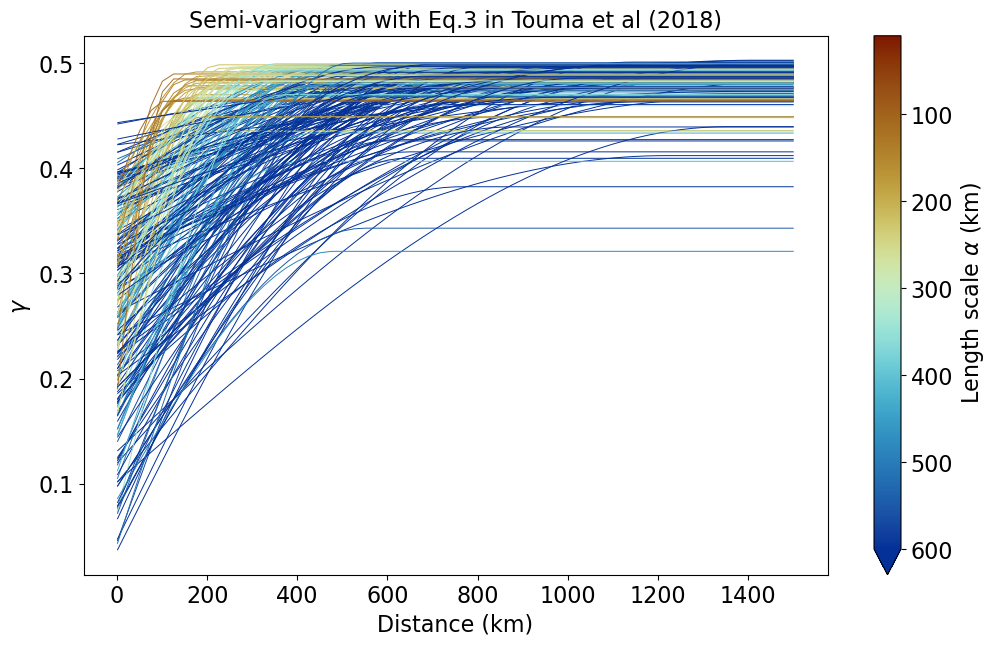

In [72]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

norm = Normalize(vmin=10, vmax=600)
cmap = cmc.roma

lc_demo = color_line(lines_demo, np.array(alpha_demo), cmap, norm,alpha=1.0, linewidth=0.7)
ax1.add_collection(lc_demo)
# ax.set_ylim(-1.5, 1.5)  # Adjust based on your data range
cbar = plt.colorbar(lc_demo, ax=ax1, label=r'Length scale $\alpha$ (km)',extend="max")
cbar.ax.invert_yaxis()  # This inverts only the colorbar, not the data

ax1.set_xlim(bins.min(), bins.max())
ax1.autoscale()

plt.xlabel("Distance (km)")
plt.ylabel("$\gamma$")
plt.title("Semi-variogram with Eq.3 in Touma et al (2018)")

In [312]:
df_scale_wrong = pd.read_csv(f"/g/data/k10/dl6968/Rain_gauge_scale/data/all_AU_fixed/{spec_id}_scale_list_all_events.csv")

In [313]:
scale_old = []
scale_new = []
date_list = []
for dates in df_scale["extreme_dates"]:
    if dates in df_scale_wrong["extreme_dates"].values:
        scale_new.append(df_scale["scale"][df_scale["extreme_dates"]==dates].values[0] )
        scale_old.append(df_scale_wrong["scale"][df_scale_wrong["extreme_dates"]==dates].values[0])
        date_list.append(dates)

In [314]:
len(scale_old)

101

(-1.0, 2200.0)

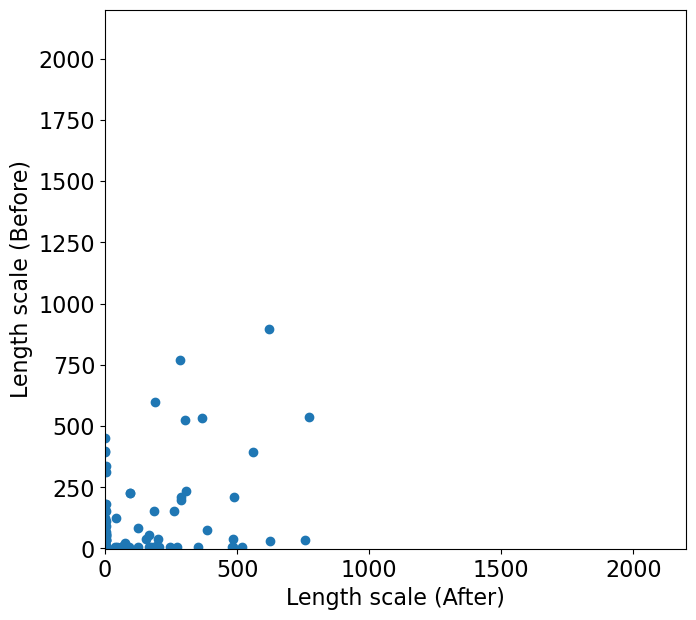

In [315]:
plt.figure(figsize=(7.5,7))
plt.scatter(scale_new, scale_old)
plt.xlabel("Length scale (After)")
plt.ylabel("Length scale (Before)")
plt.xlim([-1,2200])
plt.ylim([-1,2200])

In [43]:
np.array(date_list)[np.argwhere((np.array(scale_new)<100) & (np.array(scale_old)>500))]

array([['1981-02-07'],
       ['1999-03-03']], dtype='<U10')

In [44]:
df_scale["scale"][df_scale["extreme_dates"]=='1999-03-03']

430    90.298763
Name: scale, dtype: float64

In [45]:
df_scale_wrong["scale"][df_scale_wrong["extreme_dates"]=='1999-03-03']

416    632.189741
Name: scale, dtype: float64